In [71]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.ticker import LogLocator, FuncFormatter
from matplotlib.lines import Line2D

In [72]:
#Ajuste de exibição de tabelas

# Mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Exibir sem cortar o conteúdo
pd.set_option('display.max_colwidth', None)

In [73]:
dim_teachers = pd.read_csv("dim_teachers.csv")
teachers_contents_interactions = pd.read_csv("fct_teachers_contents_interactions.csv")
teachers_entries = pd.read_csv("fct_teachers_entries.csv")

formation = pd.read_csv("stg_formation.csv")
mari_ia_conversation = pd.read_csv("stg_mari_ia_conversation.csv")
mari_ia_reports = pd.read_csv("stg_mari_ia_reports.csv")

In [59]:
teachers_entries = pd.read_csv("fct_teachers_entries.csv")

# teachers_entries
### entradas/sessões dos professores na plataforma  
unique_id: Identificador único do professor (FK para dim_teachers)  
user_type: Tipo do usuário  
data_inicio: Data/hora de início da sessão  
data_fim: Data/hora de fim da sessão

2.446.050 linhas no df.


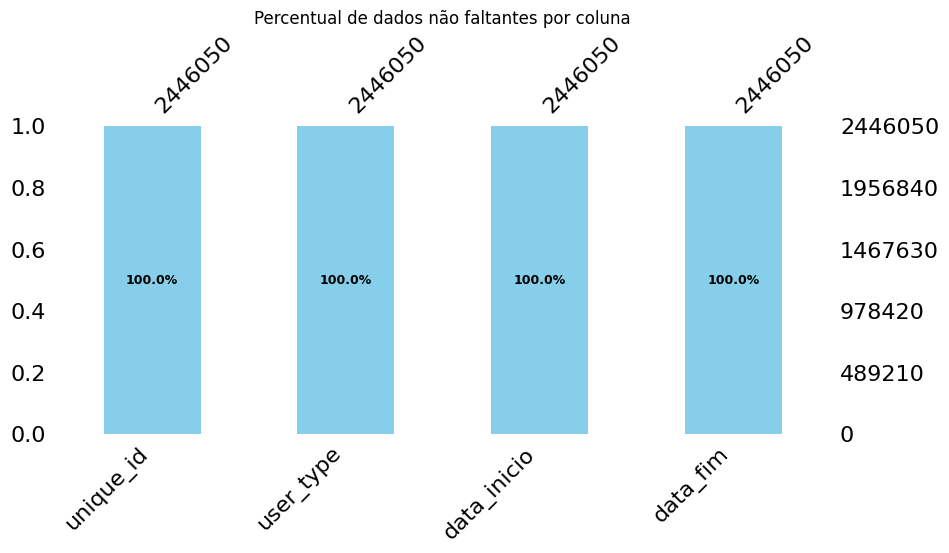

In [75]:
df = teachers_entries

print(f"{len(df):,} linhas no df.".replace(",", "."))

# Gráfico padrão do missingno
ax = msno.bar(df, figsize=(10,4), color='skyblue')

# Calcular porcentagem de não-nulos
total = len(df)
non_missing_pct = df.notna().sum() / total * 100

# Adicionar os valores dentro das barras
for p, perc in zip(ax.patches, non_missing_pct):
    ax.text(
        p.get_x() + p.get_width()/2,   # centro da barra
        p.get_height()/2,              # meio da barra (vertical)
        f"{perc:.1f}%", 
        ha='center', va='center', fontsize=9, color='black', fontweight='bold'
    )

plt.title("Percentual de dados não faltantes por coluna")
plt.show()

In [78]:
teachers_entries["data_inicio"] = pd.to_datetime(teachers_entries["data_inicio"], errors="coerce")
teachers_entries["data_fim"] = pd.to_datetime(teachers_entries["data_fim"], errors="coerce")

teachers_entries["tempo_sessao"] = teachers_entries["data_fim"] - teachers_entries["data_inicio"]
teachers_entries["tempo_sessao"] = teachers_entries["tempo_sessao"].dt.total_seconds() / 3600

teachers_entries["ano"] = teachers_entries["data_inicio"].dt.year # extrai o ano

teachers_entries.head(5)

,unique_id,user_type,data_inicio,data_fim,tempo_sessao,ano
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.009084,2022
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,0.017059,2023
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.000061,2023
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.000092,2023
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.000063,2023


In [79]:
teachers_entries_agg_ano = (
    teachers_entries
    .groupby(["unique_id", "ano"], dropna=False)  # use dropna=True se quiser excluir ano nulo
    .agg(
        sessao_medio = ("tempo_sessao", "mean"),
        sessao_total = ("tempo_sessao", "sum"),
        frequencia   = ("unique_id", "size")
        # opcional: n_tipos = ("user_type", "nunique")
    )
    .reset_index()
    .sort_values(["unique_id", "ano"])
)

print(f"{len(teachers_entries_agg_ano):,} linhas no df agregado.".replace(",", "."))
teachers_entries_agg_ano.head(5)

1.379.563 linhas no df agregado.


,unique_id,ano,sessao_medio,sessao_total,frequencia
0,000005b8-e073-4b3d-858a-cc2a51f6ae76,2023,0.004246,0.004246,1
1,00000ac4-2412-4cba-a7fd-000271cd2459,2022,0.000060,0.000060,1
2,00001d14-1398-4e03-b1b7-561cb2d2423a,2024,0.000160,0.000321,2
3,00003562-eb2f-481b-a082-f30dc8cb3d4a,2023,0.028174,0.056348,2
4,00003a13-91d1-46bf-934d-72f17f4c5a12,2024,0.005439,0.005439,1


1.379.563 linhas no df agregado.


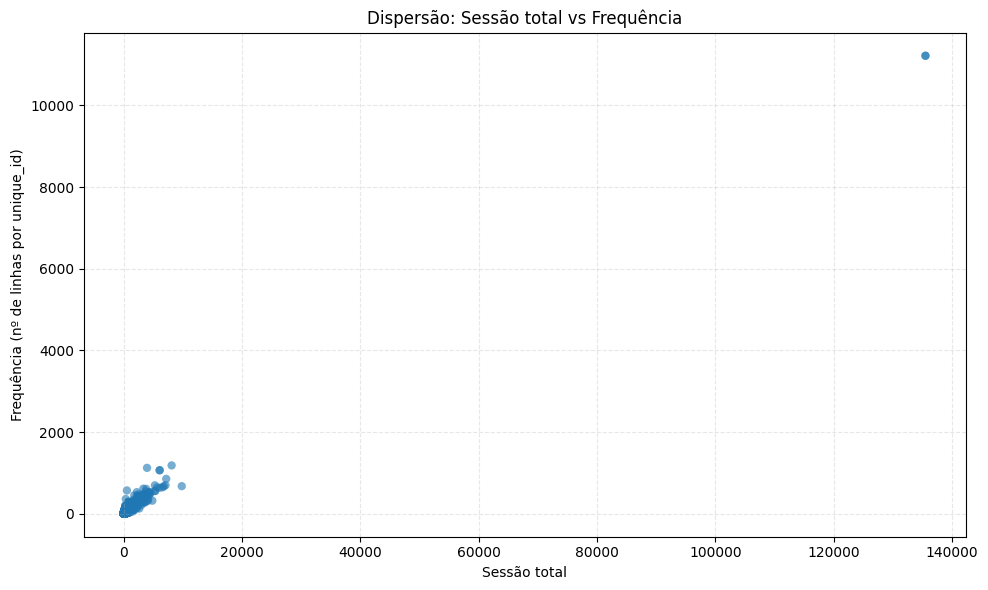

In [37]:
# Detecta o nome certo da coluna de média
xcol = "sessao_total" if "sessao_total" in teachers_entries_agg.columns else "sessao_total"

# Seleciona dados e remove NaN
plot_df = teachers_entries_agg[[xcol, "frequencia"]].dropna()

plt.figure(figsize=(10,6))
plt.scatter(plot_df[xcol], plot_df["frequencia"], alpha=0.6, edgecolors="none")
plt.xlabel("Sessão total")
plt.ylabel("Frequência (nº de linhas por unique_id)")
plt.title("Dispersão: Sessão total vs Frequência")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

1.317.993 pontos após o filtro


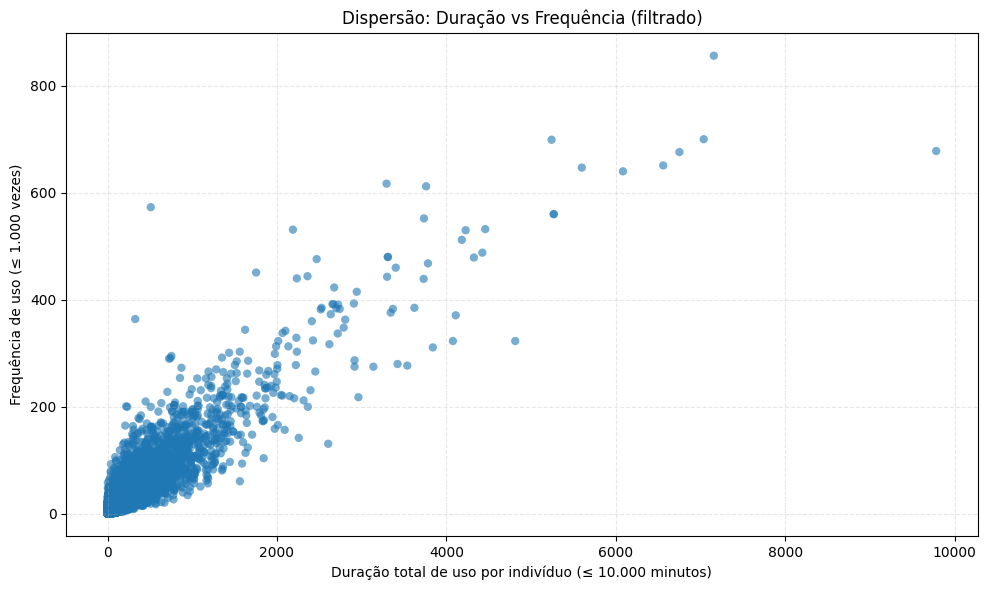

In [38]:
xcol = "sessao_total"

# garantir numérico (se já for, não tem problema)
teachers_entries_agg[xcol] = pd.to_numeric(teachers_entries_agg[xcol], errors="coerce")
teachers_entries_agg["frequencia"] = pd.to_numeric(teachers_entries_agg["frequencia"], errors="coerce")

plot_df = teachers_entries_agg[[xcol, "frequencia"]].dropna()

# filtro nos dois eixos
mask = (plot_df[xcol] <= 10_000) & (plot_df["frequencia"] <= 1_000)
plot_df_f = plot_df.loc[mask]

print(f"{len(plot_df_f):,} pontos após o filtro".replace(",", "."))

plt.figure(figsize=(10,6))
plt.scatter(plot_df_f[xcol], plot_df_f["frequencia"], alpha=0.6, edgecolors="none")
plt.xlabel("Duração total de uso por indivíduo (≤ 10.000 minutos)")
plt.ylabel("Frequência de uso (≤ 1.000 vezes)")
plt.title("Dispersão: Duração vs Frequência (filtrado)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


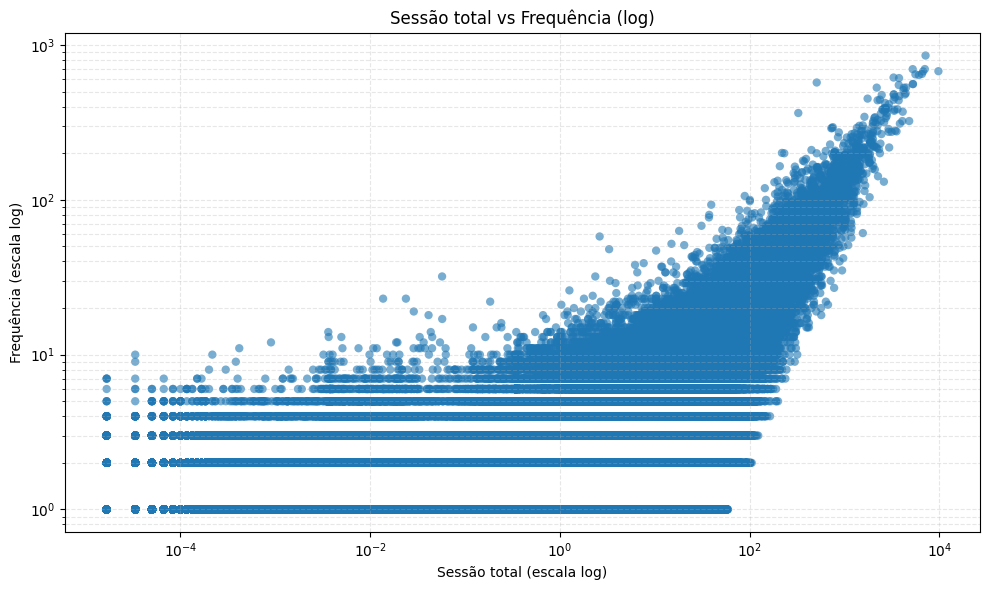

In [40]:
xcol = "sessao_total"

# Seleciona, garante numérico e filtra
plot_df = (
    teachers_entries_agg[[xcol, "frequencia"]]
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
)

mask = (
    (plot_df[xcol] > 0) & (plot_df["frequencia"] > 0) &  # necessário p/ log
    (plot_df[xcol] <= 10_000) &
    (plot_df["frequencia"] <= 1_000)
)
plot_df = plot_df.loc[mask]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(plot_df[xcol], plot_df["frequencia"], alpha=0.6, edgecolors="none")

# ↓↓↓ escalas log (use uma ou ambas)
ax.set_xscale("log")   # só X em log
ax.set_yscale("log")   # só Y em log (com as duas linhas, vira log-log)

ax.set_xlabel("Sessão total (escala log)")
ax.set_ylabel("Frequência (escala log)")
ax.set_title("Sessão total vs Frequência (log)")
ax.grid(True, which="both", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\1853373952.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


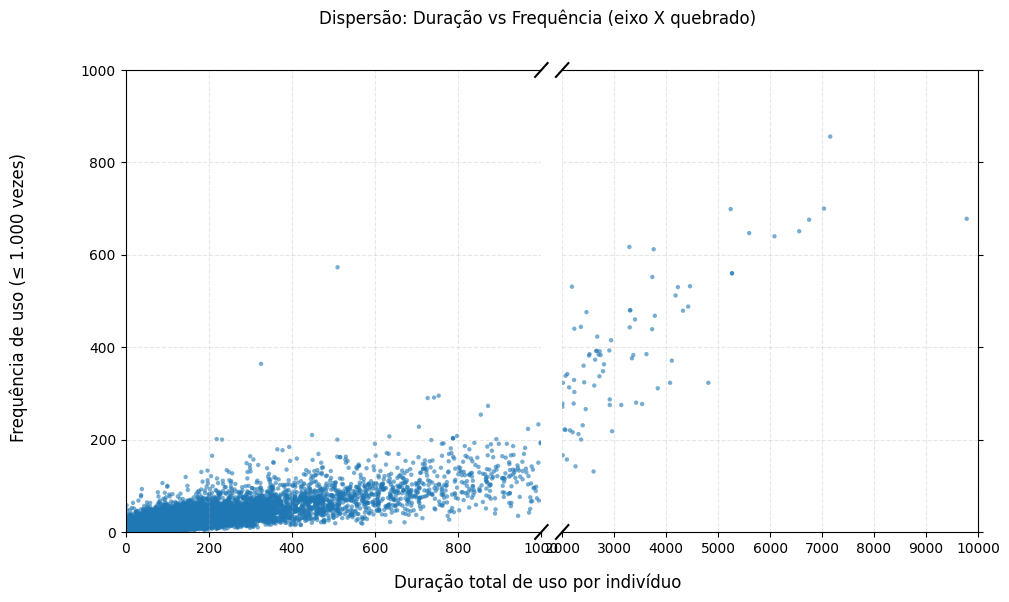

In [41]:
xcol, ycol = "sessao_total", "frequencia"

# Base filtrada (até 10.000 no X e 1.000 no Y)
df = (
    teachers_entries_agg[[xcol, ycol]]
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
)
df = df[(df[xcol] <= 10_000) & (df[ycol] <= 1_000)]

left  = df[df[xcol] <= 1_000]      # 1ª metade: 0–1000
right = df[df[xcol] >= 2_000]      # 2ª metade: 2000–10000 (pula o intervalo 1000–2000)

import matplotlib.pyplot as plt

fig, (axL, axR) = plt.subplots(
    1, 2, sharey=True, figsize=(11, 6),
    gridspec_kw={"wspace": 0.05, "width_ratios": [1, 1]}  # 50/50; ajuste se quiser
)

# Dispersões
axL.scatter(left[xcol],  left[ycol],  s=10, alpha=0.6, edgecolors="none", rasterized=True)
axR.scatter(right[xcol], right[ycol], s=10, alpha=0.6, edgecolors="none", rasterized=True)

# Limites
axL.set_xlim(0, 1_000)
axR.set_xlim(2_000, 10_000)
axL.set_ylim(0, 1_000)

# Grade
for ax in (axL, axR):
    ax.grid(True, linestyle="--", alpha=0.3)

# Esconde eixos centrais e põe as marquinhas de quebra
axL.spines["right"].set_visible(False)
axR.spines["left"].set_visible(False)
axR.tick_params(labelleft=False)   # evita rótulos duplos no Y
axR.yaxis.tick_right()             # opcional: ticks do Y do lado direito

d = .015  # tamanho das “quebras”
kwargs = dict(transform=axL.transAxes, color="k", clip_on=False)
axL.plot((1-d, 1+d), (-d, +d), **kwargs)        # diagonais no canto direito do eixo esquerdo
axL.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=axR.transAxes)          # diagonais no canto esquerdo do eixo direito
axR.plot((-d, +d), (-d, +d), **kwargs)
axR.plot((-d, +d), (1-d, 1+d), **kwargs)

# Títulos e rótulos “globais”
fig.suptitle("Dispersão: Duração vs Frequência (eixo X quebrado)")
fig.supxlabel("Duração total de uso por indivíduo")
fig.supylabel("Frequência de uso (≤ 1.000 vezes)")

plt.tight_layout()
plt.show()


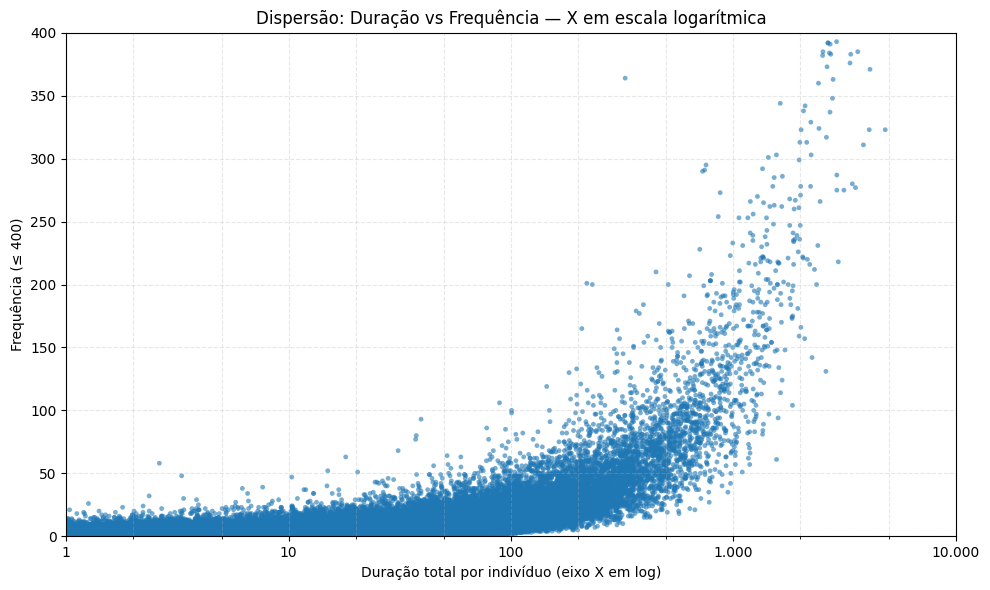

In [49]:
xcol, ycol = "sessao_total", "frequencia"

# prepara e filtra (limites como no seu exemplo)
df = (
    teachers_entries_agg[[xcol, ycol]]
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
)
df = df[(df[xcol] > 0) & (df[xcol] <= 10_000) & (df[ycol] <= 400)]

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df[xcol], df[ycol], s=12, alpha=0.6, edgecolors="none", rasterized=True)

# <<< eixo X em log (suave, contínuo) >>>
ax.set_xscale("log")
ax.set_xlim(1, 10_000)   # ajuste se quiser outro mínimo > 0
ax.set_ylim(0, 400)

# grades e ticks “bonitos”
ax.grid(True, which="both", linestyle="--", alpha=0.3)
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

ax.set_xlabel("Duração total por indivíduo (eixo X em log)")
ax.set_ylabel("Frequência (≤ 400)")
ax.set_title("Dispersão: Duração vs Frequência — X em escala logarítmica")
plt.tight_layout()
plt.show()


C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\3923017249.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(anos))  # paleta discreta por ano
C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\3923017249.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


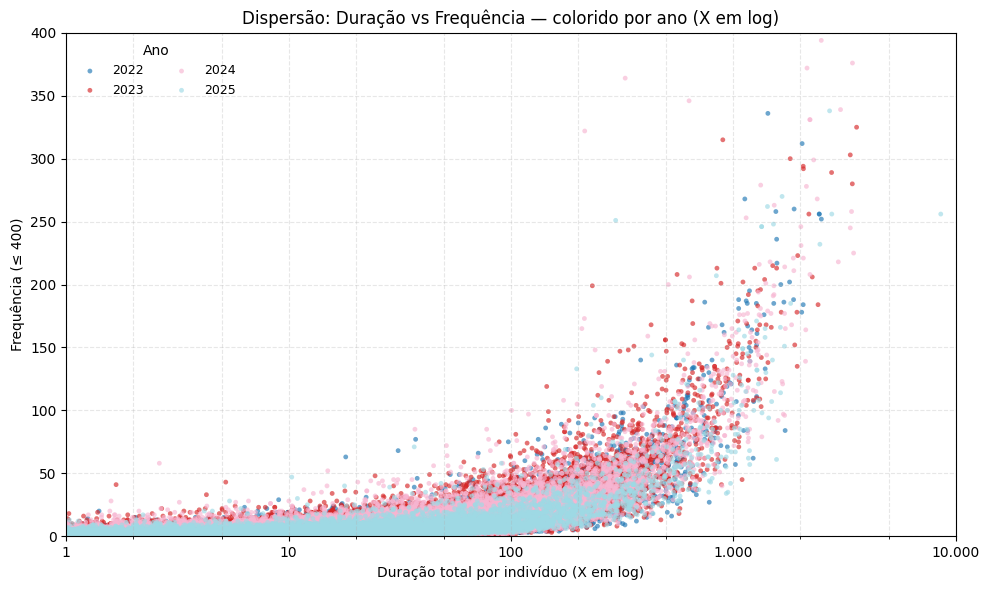

In [50]:
from matplotlib.ticker import LogLocator, FuncFormatter

xcol, ycol = "sessao_total", "frequencia"

# --- usa a base com ano ---
df = (
    teachers_entries_agg_ano[[xcol, ycol, "ano"]]
    .dropna(subset=[xcol, ycol, "ano"])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtros (X > 0 por causa do log em X)
df = df[(df[xcol] > 0) & (df[xcol] <= 10_000) & (df[ycol] >= 0) & (df[ycol] <= 400)]

anos = sorted(df["ano"].unique())
cmap = plt.cm.get_cmap("tab20", len(anos))  # paleta discreta por ano

fig, ax = plt.subplots(figsize=(10,6))

for i, ano in enumerate(anos):
    d = df[df["ano"] == ano]
    ax.scatter(
        d[xcol], d[ycol],
        s=12, alpha=0.65, edgecolors="none", rasterized=True,
        color=cmap(i), label=str(int(ano))
    )

# --- eixo X em log (suave/contínuo) ---
ax.set_xscale("log")
ax.set_xlim(1, 10_000)
ax.set_ylim(0, 400)

# grades e ticks
ax.grid(True, which="both", linestyle="--", alpha=0.3)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

ax.set_xlabel("Duração total por indivíduo (X em log)")
ax.set_ylabel("Frequência (≤ 400)")
ax.set_title("Dispersão: Duração vs Frequência — colorido por ano (X em log)")

ax.legend(title="Ano", ncol=2, fontsize=9, frameon=False)  # ajuste ncol conforme nº de anos
plt.tight_layout()
plt.show()

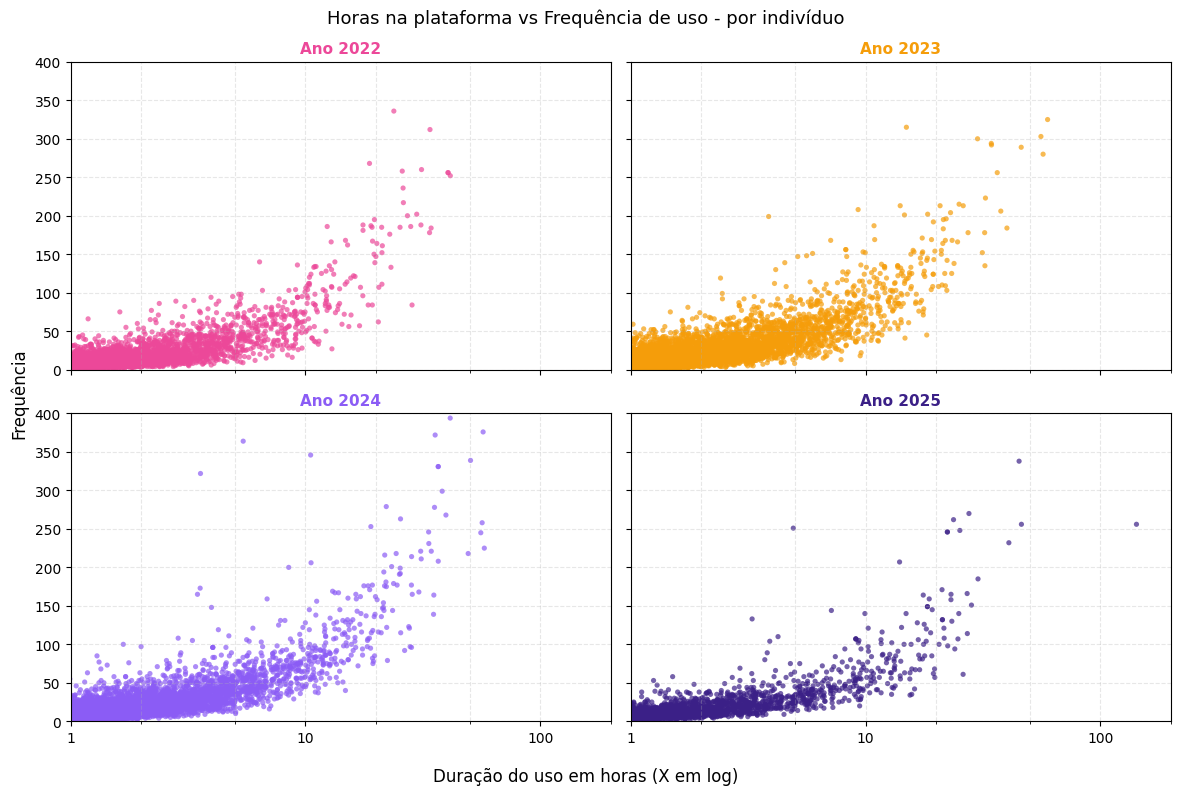

In [80]:
xcol, ycol = "sessao_total", "frequencia"

# --- dados: usa a base com 'ano' ---
df = (
    teachers_entries_agg_ano[[xcol, ycol, "ano"]]
    .dropna(subset=[xcol, ycol, "ano"])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtros (X > 0 por causa do log em X; Y até 400)
df = df[(df[xcol] > 0) & (df[xcol] <= 200) & (df[ycol] >= 0) & (df[ycol] <= 400)]

# Quais anos vão para o grid 2x2?
anos = sorted(df["ano"].unique())
# Se houver mais que 4, pegue os 4 mais recentes; ajuste se quiser outros:
anos_plot = anos[-4:] if len(anos) > 4 else anos

# Paleta fixa pedida:
palette = ["#ec4899", "#f59d0a", "#8b5cf5", "#3b2087"]
color_map = {a: palette[i] for i, a in enumerate(anos_plot)}

# --- figura 2x2 ---
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

# Plota cada ano no seu painel
for i, ano in enumerate(anos_plot):
    ax = axes[i]
    d = df[df["ano"] == ano]
    ax.scatter(
        d[xcol], d[ycol],
        s=14, alpha=0.7, edgecolors="none", rasterized=True,
        color=color_map[ano]
    )

    # Escalas / limites por painel
    ax.set_xscale("log")
    ax.set_xlim(1, 200)
    ax.set_ylim(0, 400)
    ax.grid(True, which="both", linestyle="--", alpha=0.3)

    # Título do painel com o ano
    ax.set_title(f"Ano {int(ano)}", fontsize=11, fontweight="bold", color=color_map[ano])

# Se tiver menos de 4 anos, esconda eixos sobrando
for j in range(len(anos_plot), 4):
    axes[j].set_visible(False)

# Ticks e formatação (aplica a todos os eixos visíveis)
for ax in axes[:len(anos_plot)]:
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

# Rótulos “globais”
fig.suptitle("Horas na plataforma vs Frequência de uso - por indivíduo", fontsize=13)
fig.supxlabel("Duração do uso em horas (X em log)")
fig.supylabel("Frequência")

plt.tight_layout()
plt.show()


Contagem por ano:


quadrante,"Q1 (≤6, ≤100)","Q2 (>6, ≤100)","Q3 (≤6, >100)","Q4 (>6, >100)"
ano,,,,
2022,212937,189,0,72
2023,431532,336,10,133
2024,536265,330,12,125
2025,179200,172,4,48



Percentual por ano:


quadrante,"Q1 (≤6, ≤100)","Q2 (>6, ≤100)","Q3 (≤6, >100)","Q4 (>6, >100)"
ano,,,,
2022,0.999,0.001,0.0,0.0
2023,0.999,0.001,0.0,0.0
2024,0.999,0.001,0.0,0.0
2025,0.999,0.001,0.0,0.0



Contagem total:
quadrante
Q1 (≤6, ≤100)    1359934
Q2 (>6, ≤100)       1027
Q3 (≤6, >100)         26
Q4 (>6, >100)        378
Name: count, dtype: int64

Percentual total:
quadrante
Q1 (≤6, ≤100)    0.999
Q2 (>6, ≤100)    0.001
Q3 (≤6, >100)    0.000
Q4 (>6, >100)    0.000
Name: count, dtype: float64


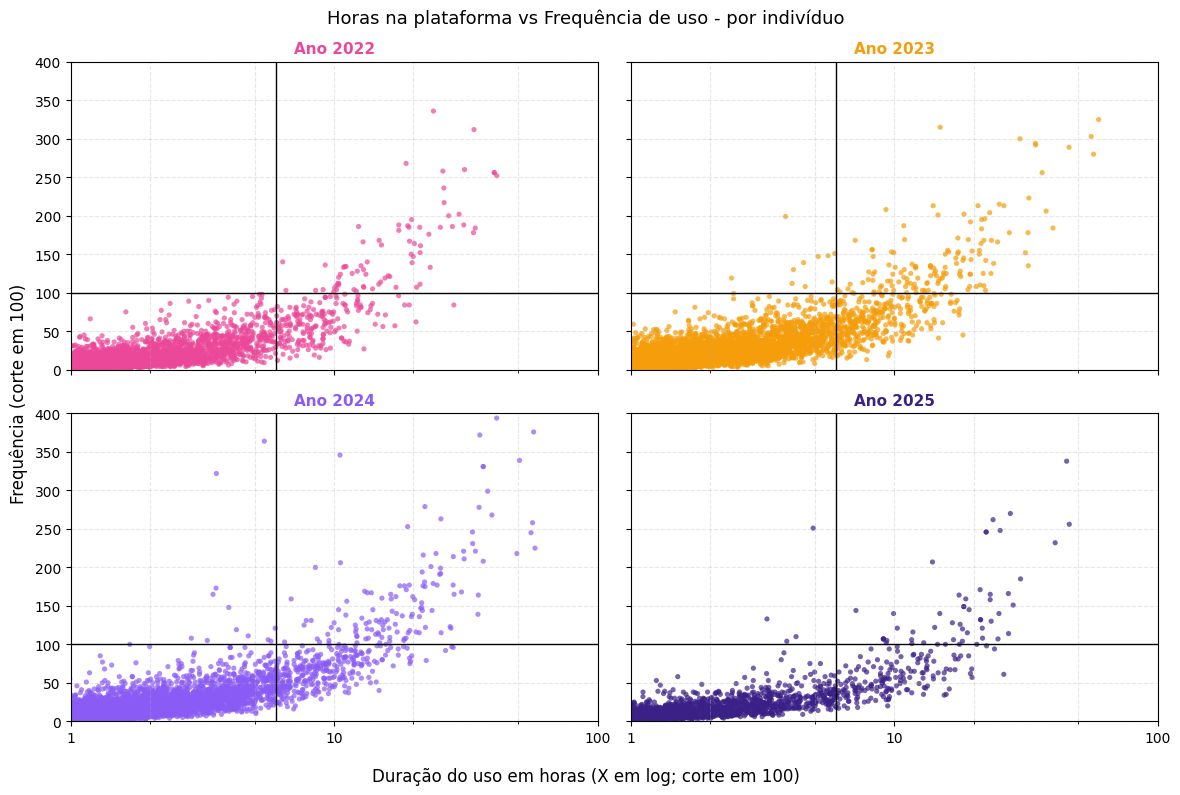

In [81]:
xcol, ycol = "sessao_total", "frequencia"
x_max, y_max = 100, 400       # limites do gráfico
x_thr, y_thr = 6, 100          # cortes dos quadrantes

# -----------------------------
# 1) Preparar dados e CONTAR por quadrante
# -----------------------------
df = (
    teachers_entries_agg_ano[[xcol, ycol, "ano"]]
    .dropna(subset=[xcol, ycol, "ano"])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtros (X>0 por causa do log no X)
df = df[(df[xcol] > 0) & (df[xcol] <= x_max) & (df[ycol] >= 0) & (df[ycol] <= y_max)]

# Definir quadrante
conds = [
    (df[xcol] <= x_thr) & (df[ycol] <= y_thr),  # Q1
    (df[xcol] >  x_thr) & (df[ycol] <= y_thr),  # Q2
    (df[xcol] <= x_thr) & (df[ycol] >  y_thr),  # Q3
    (df[xcol] >  x_thr) & (df[ycol] >  y_thr),  # Q4
]
labels = ["Q1 (≤6, ≤100)", "Q2 (>6, ≤100)", "Q3 (≤6, >100)", "Q4 (>6, >100)"]
df["quadrante"] = np.select(conds, labels, default="Outros")

# Contagem por ano
counts_by_year = (
    df.groupby(["ano", "quadrante"]).size()
      .unstack(fill_value=0)
      .reindex(columns=labels, fill_value=0)
)
# Percentuais por ano (opcional)
perc_by_year = (counts_by_year
                .div(counts_by_year.sum(axis=1), axis=0)
                .round(3))

# Contagem total (todas os anos juntos)
counts_total = df["quadrante"].value_counts().reindex(labels, fill_value=0)
perc_total   = (counts_total / counts_total.sum()).round(3)

print("Contagem por ano:")
display(counts_by_year)
print("\nPercentual por ano:")
display(perc_by_year)
print("\nContagem total:")
print(counts_total)
print("\nPercentual total:")
print(perc_total)

# -----------------------------
# 2) Plot 2×2 (um painel por ano), com linhas de corte e contagens no painel
# -----------------------------
# Quais anos vão para o grid 2x2? (pegue os 4 mais recentes)
anos = sorted(df["ano"].unique())
anos_plot = anos[-4:] if len(anos) > 4 else anos

# Cores pedidas, na ordem dos anos usados
palette = ["#ec4899", "#f59d0a", "#8b5cf5", "#3b2087"]
color_map = {a: palette[i] for i, a in enumerate(anos_plot)}

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

for i, ano in enumerate(anos_plot):
    ax = axes[i]
    d = df[df["ano"] == ano]

    # Scatter
    ax.scatter(d[xcol], d[ycol], s=14, alpha=0.7, edgecolors="none",
               color=color_map[ano], rasterized=True)

    # Escalas/limites
    ax.set_xscale("log")
    ax.set_xlim(1, x_max)
    ax.set_ylim(0, y_max)

    # Linhas de corte
    ax.axvline(x_thr, color="black", lw=1)
    ax.axhline(y_thr, color="black", lw=1)

    # Grade
    ax.grid(True, which="both", linestyle="--", alpha=0.3)

    # Título
    ax.set_title(f"Ano {int(ano)}", fontsize=11, fontweight="bold", color=color_map[ano])

    # Contagens dos quadrantes desse ano
    q1 = ((d[xcol] <= x_thr) & (d[ycol] <= y_thr)).sum()
    q2 = ((d[xcol] >  x_thr) & (d[ycol] <= y_thr)).sum()
    q3 = ((d[xcol] <= x_thr) & (d[ycol] >  y_thr)).sum()
    q4 = ((d[xcol] >  x_thr) & (d[ycol] >  y_thr)).sum()

    # Anotar dentro de cada quadrante (coordenadas relativas ao eixo: 0–1)
    #ax.text(0.25, 0.25, f"Q1: {q1:,}".replace(",", "."), transform=ax.transAxes,
    #        ha="center", va="center", fontsize=10)
    #ax.text(0.75, 0.25, f"Q2: {q2:,}".replace(",", "."), transform=ax.transAxes,
    #        ha="center", va="center", fontsize=10)
    #ax.text(0.25, 0.75, f"Q3: {q3:,}".replace(",", "."), transform=ax.transAxes,
    #        ha="center", va="center", fontsize=10)
    #ax.text(0.75, 0.75, f"Q4: {q4:,}".replace(",", "."), transform=ax.transAxes,
    #        ha="center", va="center", fontsize=10)

# Esconde eixos sobrando se tiver < 4 anos
for j in range(len(anos_plot), 4):
    axes[j].set_visible(False)

# Ticks X bonitos em log
for ax in axes[:len(anos_plot)]:
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

# Rótulos “globais”
fig.suptitle("Horas na plataforma vs Frequência de uso - por indivíduo", fontsize=13)
fig.supxlabel("Duração do uso em horas (X em log; corte em 100)")
fig.supylabel(f"Frequência (corte em {y_thr})")

plt.tight_layout()
plt.show()


In [58]:
xcol, ycol = "sessao_total", "frequencia"
mask = (
    (teachers_entries_agg_ano[xcol] > 0) &
    (teachers_entries_agg_ano[xcol] <= 10_000) &
    (teachers_entries_agg_ano[ycol] >= 0) &
    (teachers_entries_agg_ano[ycol] <= 400)
)

obs_plot_por_ano = (
    teachers_entries_agg_ano.loc[mask]
    .groupby("ano").size()
    .rename("n_obs_plot")
    .reset_index()
    .sort_values("ano")
)

fmt = lambda v: f"{int(v):,}".replace(",", ".")

display(
    obs_plot_por_ano.style.format({"n_obs_plot": fmt})
)


,ano,n_obs_plot
0,2022,213.198
1,2023,432.011
2,2024,536.732
3,2025,179.425


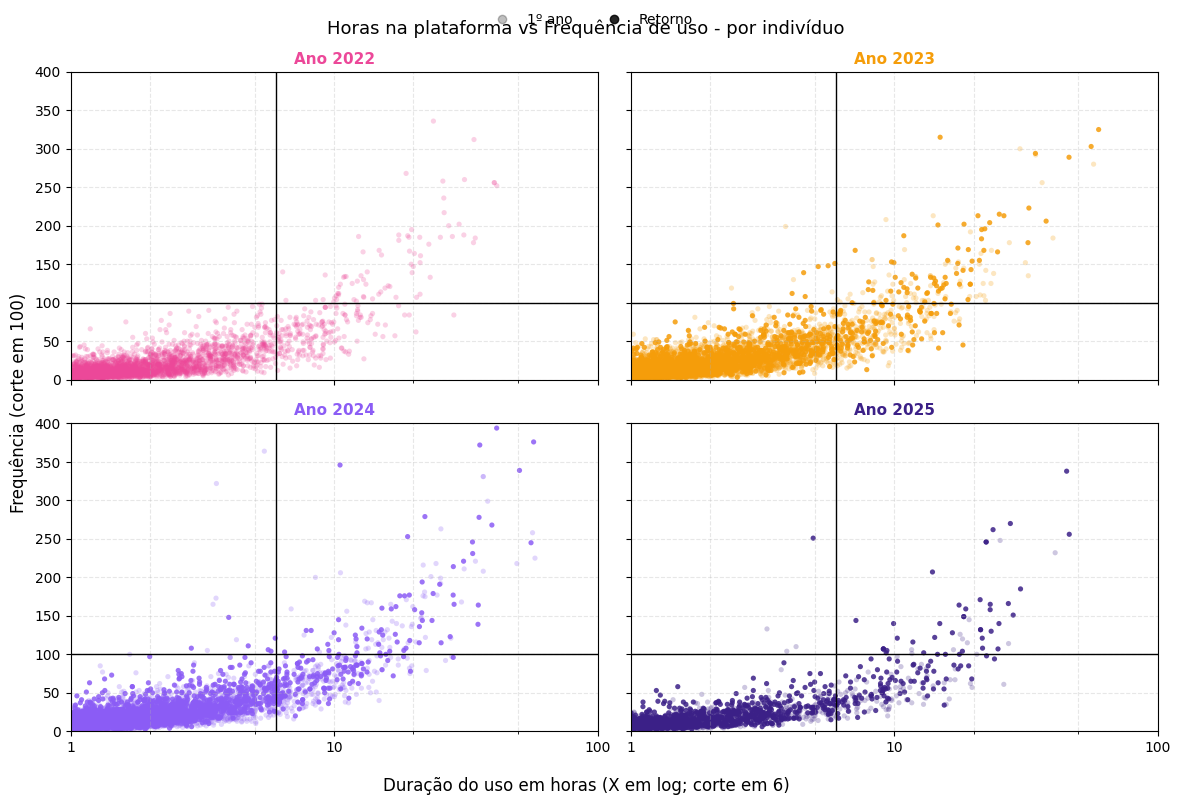

In [66]:
xcol, ycol = "sessao_total", "frequencia"
x_max, y_max = 100, 400      # limites do gráfico
x_thr, y_thr = 6, 100        # cortes dos quadrantes

# -----------------------------
# 1) Preparar dados + flag "primeiro ano" por unique_id
# -----------------------------
df = (
    teachers_entries_agg_ano[["unique_id", xcol, ycol, "ano"]]
    .dropna(subset=[xcol, ycol, "ano", "unique_id"])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtros (X>0 por causa do log no X)
df = df[(df[xcol] > 0) & (df[xcol] <= x_max) & (df[ycol] >= 0) & (df[ycol] <= y_max)]

# primeiro ano em que cada unique_id aparece
df["first_year_for_id"] = df.groupby("unique_id")["ano"].transform("min")
df["is_first_year"] = df["ano"] == df["first_year_for_id"]   # True = 1ª vez na base

# -----------------------------
# 2) Plot 2×2 por ano, com alpha diferente
# -----------------------------
anos = sorted(df["ano"].unique())
anos_plot = anos[-4:] if len(anos) > 4 else anos

palette = ["#ec4899", "#f59d0a", "#8b5cf5", "#3b2087"]
color_map = {a: palette[i] for i, a in enumerate(anos_plot)}

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

for i, ano in enumerate(anos_plot):
    ax = axes[i]
    d = df[df["ano"] == ano]

    # 1ª vez (mais claro)
    d_first = d[d["is_first_year"]]
    ax.scatter(
        d_first[xcol], d_first[ycol],
        s=14, alpha=0.25, edgecolors="none", rasterized=True,
        color=color_map[ano], label="1º ano"
    )

    # Retorno (mais escuro)
    d_ret = d[~d["is_first_year"]]
    ax.scatter(
        d_ret[xcol], d_ret[ycol],
        s=14, alpha=0.85, edgecolors="none", rasterized=True,
        color=color_map[ano], label="Retorno"
    )

    # Escalas/limites
    ax.set_xscale("log")
    ax.set_xlim(1, x_max)
    ax.set_ylim(0, y_max)

    # Linhas de corte
    ax.axvline(x_thr, color="black", lw=1)
    ax.axhline(y_thr, color="black", lw=1)

    # Grade e título
    ax.grid(True, which="both", linestyle="--", alpha=0.3)
    ax.set_title(f"Ano {int(ano)}", fontsize=11, fontweight="bold", color=color_map[ano])

# Esconde eixos sobrando se tiver < 4 anos
for j in range(len(anos_plot), 4):
    axes[j].set_visible(False)

# Ticks X em log bem formatados
for ax in axes[:len(anos_plot)]:
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

# Legenda única para o grid
handles = [
    Line2D([0], [0], marker='o', linestyle='', color='k', alpha=0.25, label='1º ano'),
    Line2D([0], [0], marker='o', linestyle='', color='k', alpha=0.85, label='Retorno'),
]
fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False)

# Rótulos globais
fig.suptitle("Horas na plataforma vs Frequência de uso - por indivíduo", fontsize=13)
fig.supxlabel("Duração do uso em horas (X em log; corte em 6)")
fig.supylabel(f"Frequência (corte em {y_thr})")

plt.tight_layout()
plt.show()


C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\1163329554.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


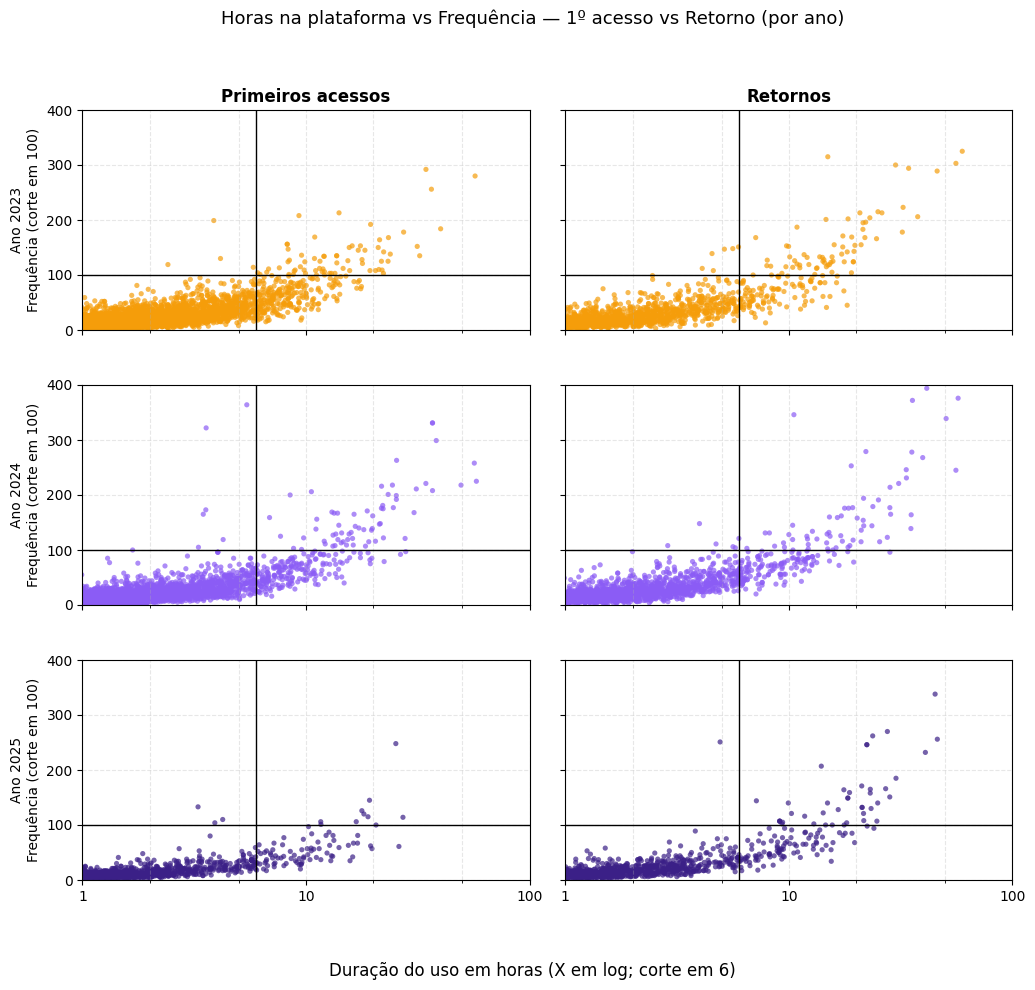

In [68]:
# ========= Parâmetros =========
xcol, ycol = "sessao_total", "frequencia"
x_max, y_max = 100, 400     # limites do gráfico
x_thr, y_thr = 6, 100       # cortes dos quadrantes
anos_plot = [2023, 2024, 2025]
color_by_year = {2023:"#f59d0a", 2024:"#8b5cf5", 2025:"#3b2087"}

# ========= 1) Primeiro ano por unique_id (na base inteira) =========
first_year_map = (
    teachers_entries_agg_ano[["unique_id", "ano"]]
    .dropna(subset=["unique_id", "ano"])
    .groupby("unique_id")["ano"].min()
)

# ========= 2) Preparar DF e flags =========
df = (
    teachers_entries_agg_ano[["unique_id", "ano", xcol, ycol]]
    .dropna(subset=["unique_id", "ano", xcol, ycol])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtro de anos e limites
df = df[df["ano"].astype(int).isin(anos_plot)]
df = df[(df[xcol] > 0) & (df[xcol] <= x_max) & (df[ycol] >= 0) & (df[ycol] <= y_max)]

# flag: é o 1º ano que esse unique_id aparece?
df["first_year_for_id"] = df["unique_id"].map(first_year_map)
df["is_first_year"] = df["ano"] == df["first_year_for_id"]

# ========= 3) Grid 3×2 (coluna 1 = primeiros acessos, coluna 2 = retornos) =========
fig, axes = plt.subplots(
    nrows=len(anos_plot), ncols=2, sharex=True, sharey=True, figsize=(12, 10),
    gridspec_kw={"hspace":0.25, "wspace":0.08}
)

for i, ano in enumerate(anos_plot):
    color = color_by_year[ano]
    d = df[df["ano"].astype(int) == ano]

    # Primeiros acessos (coluna 0)
    axL = axes[i, 0]
    d_first = d[d["is_first_year"]]
    axL.scatter(d_first[xcol], d_first[ycol], s=14, alpha=0.7,
                edgecolors="none", rasterized=True, color=color)
    axL.set_xscale("log"); axL.set_xlim(1, x_max); axL.set_ylim(0, y_max)
    axL.axvline(x_thr, color="black", lw=1); axL.axhline(y_thr, color="black", lw=1)
    axL.grid(True, which="both", linestyle="--", alpha=0.3)

    # Retornos (coluna 1)
    axR = axes[i, 1]
    d_ret = d[~d["is_first_year"]]
    axR.scatter(d_ret[xcol], d_ret[ycol], s=14, alpha=0.7,
                edgecolors="none", rasterized=True, color=color)
    axR.set_xscale("log"); axR.set_xlim(1, x_max); axR.set_ylim(0, y_max)
    axR.axvline(x_thr, color="black", lw=1); axR.axhline(y_thr, color="black", lw=1)
    axR.grid(True, which="both", linestyle="--", alpha=0.3)

    # Rótulo de cada linha (ano)
    axes[i, 0].set_ylabel(f"Ano {ano}\nFrequência (corte em {y_thr})", fontsize=10)

# Ticks X em log bonitos (aplica na última linha)
for ax in axes[-1, :]:
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

# Títulos de coluna
axes[0,0].set_title("Primeiros acessos", fontsize=12, fontweight="bold")
axes[0,1].set_title("Retornos", fontsize=12, fontweight="bold")

# Rótulo X global
fig.supxlabel(f"Duração do uso em horas (X em log; corte em {x_thr})")
fig.suptitle("Horas na plataforma vs Frequência — 1º acesso vs Retorno (por ano)", fontsize=13)

plt.tight_layout()
plt.show()


C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\174685430.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="upper center", ncol=2, frameon=False)
C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\174685430.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


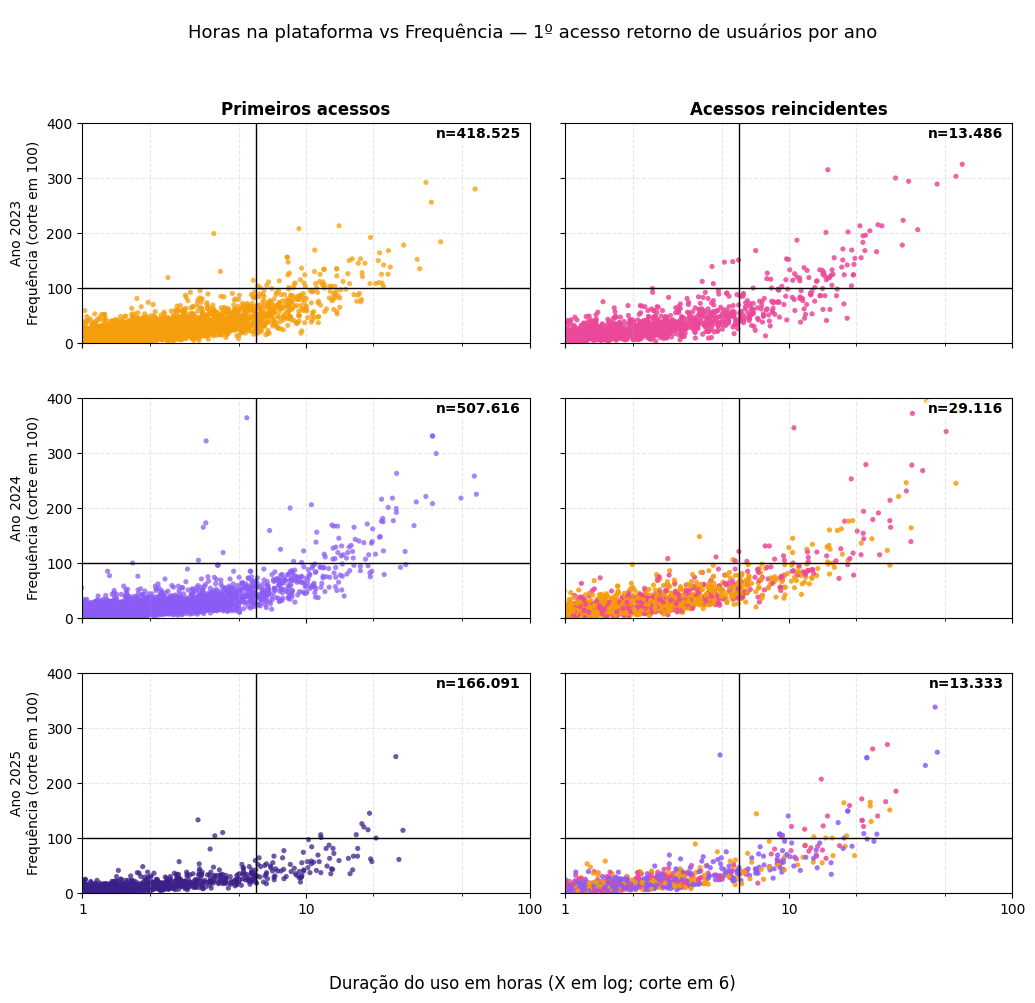

In [84]:
# ===== Parâmetros =====
xcol, ycol = "sessao_total", "frequencia"
x_max, y_max = 100, 400
x_thr, y_thr = 6, 100
anos_plot = [2023, 2024, 2025]

# Cores por ano (e cor neutra para coortes fora do range)
color_by_year = {2023: "#f59d0a", 2024: "#8b5cf5", 2025: "#3b2087"}
color_other = "#ec4899"

fmt_milhar = lambda v: f"{int(v):,}".replace(",", ".")

# ===== 1) Primeiro ano por unique_id (na base inteira) =====
first_year_map = (
    teachers_entries_agg_ano[["unique_id", "ano"]]
    .dropna(subset=["unique_id", "ano"])
    .groupby("unique_id")["ano"].min()
)

# ===== 2) Preparar DF + flags =====
df = (
    teachers_entries_agg_ano[["unique_id", "ano", xcol, ycol]]
    .dropna(subset=["unique_id", "ano", xcol, ycol])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtrar anos e limites usados no gráfico
df = df[df["ano"].astype(int).isin(anos_plot)]
df = df[(df[xcol] > 0) & (df[xcol] <= x_max) & (df[ycol] >= 0) & (df[ycol] <= y_max)]

# anotar primeiro ano do id e flag de 1º ano vs retorno
df["first_year_for_id"] = df["unique_id"].map(first_year_map)
df["is_first_year"] = df["ano"] == df["first_year_for_id"]

# helper para colorir por COORTE (ano do primeiro acesso)
def color_for_cohort(v):
    try:
        y = int(v)
    except Exception:
        return color_other
    return color_by_year.get(y, color_other)

# ===== 3) Grid 3×2 =====
fig, axes = plt.subplots(
    nrows=len(anos_plot), ncols=2, sharex=True, sharey=True,
    figsize=(12, 10), gridspec_kw={"hspace": 0.25, "wspace": 0.08}
)

for i, ano in enumerate(anos_plot):
    base_color = color_by_year[ano]
    d = df[df["ano"].astype(int) == ano]

    # ---- Coluna 0: Primeiros acessos (cor do próprio ano) ----
    axL = axes[i, 0]
    d_first = d[d["is_first_year"]]
    axL.scatter(
        d_first[xcol], d_first[ycol],
        s=14, alpha=0.75, edgecolors="none", rasterized=True, color=base_color
    )
    axL.set_xscale("log"); axL.set_xlim(1, x_max); axL.set_ylim(0, y_max)
    axL.axvline(x_thr, color="black", lw=1); axL.axhline(y_thr, color="black", lw=1)
    axL.grid(True, which="both", linestyle="--", alpha=0.3)
    axL.set_ylabel(f"Ano {ano}\nFrequência (corte em {y_thr})", fontsize=10)

    # contador
    axL.text(0.98, 0.98, f"n={fmt_milhar(len(d_first))}",
             transform=axL.transAxes, ha="right", va="top",
             fontsize=10, fontweight="bold",
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    # ---- Coluna 1: Retornos (cor pela COORTE do 1º acesso) ----
    axR = axes[i, 1]
    d_ret = d[~d["is_first_year"]]
    colors = d_ret["first_year_for_id"].apply(color_for_cohort).values  # cores por ponto
    axR.scatter(
        d_ret[xcol], d_ret[ycol],
        s=14, alpha=0.85, edgecolors="none", rasterized=True, c=colors
    )
    axR.set_xscale("log"); axR.set_xlim(1, x_max); axR.set_ylim(0, y_max)
    axR.axvline(x_thr, color="black", lw=1); axR.axhline(y_thr, color="black", lw=1)
    axR.grid(True, which="both", linestyle="--", alpha=0.3)

    # contador
    axR.text(0.98, 0.98, f"n={fmt_milhar(len(d_ret))}",
             transform=axR.transAxes, ha="right", va="top",
             fontsize=10, fontweight="bold",
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

# Títulos das colunas
axes[0, 0].set_title("Primeiros acessos", fontsize=12, fontweight="bold")
axes[0, 1].set_title("Acessos reincidentes", fontsize=12, fontweight="bold")

# Ticks X em log (na última linha)
for ax in axes[-1, :]:
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

# Legenda de coortes (para a coluna de retornos)
#handles = [
#    Line2D([0], [0], marker="o", linestyle="", color=color_by_year[2023], label="1º acesso em 2023"),
#    Line2D([0], [0], marker="o", linestyle="", color=color_by_year[2024], label="1º acesso em 2024"),
#    Line2D([0], [0], marker="o", linestyle="", color=color_by_year[2025], label="1º acesso em 2025"),
#]
# Se houver coortes fora de 2023–2025, adiciona "Outros"
#if (df["first_year_for_id"].dropna().astype(int) \
#      .isin(anos_plot) == False).any():
#    handles.append(Line2D([0], [0], marker="o", linestyle="", color=color_other, label="1º acesso: outros anos"))

fig.legend(loc="upper center", ncol=2, frameon=False)

fig.supxlabel(f"Duração do uso em horas (X em log; corte em {x_thr})")
fig.suptitle("Horas na plataforma vs Frequência — 1º acesso retorno de usuários por ano", fontsize=13)
plt.tight_layout()
plt.show()


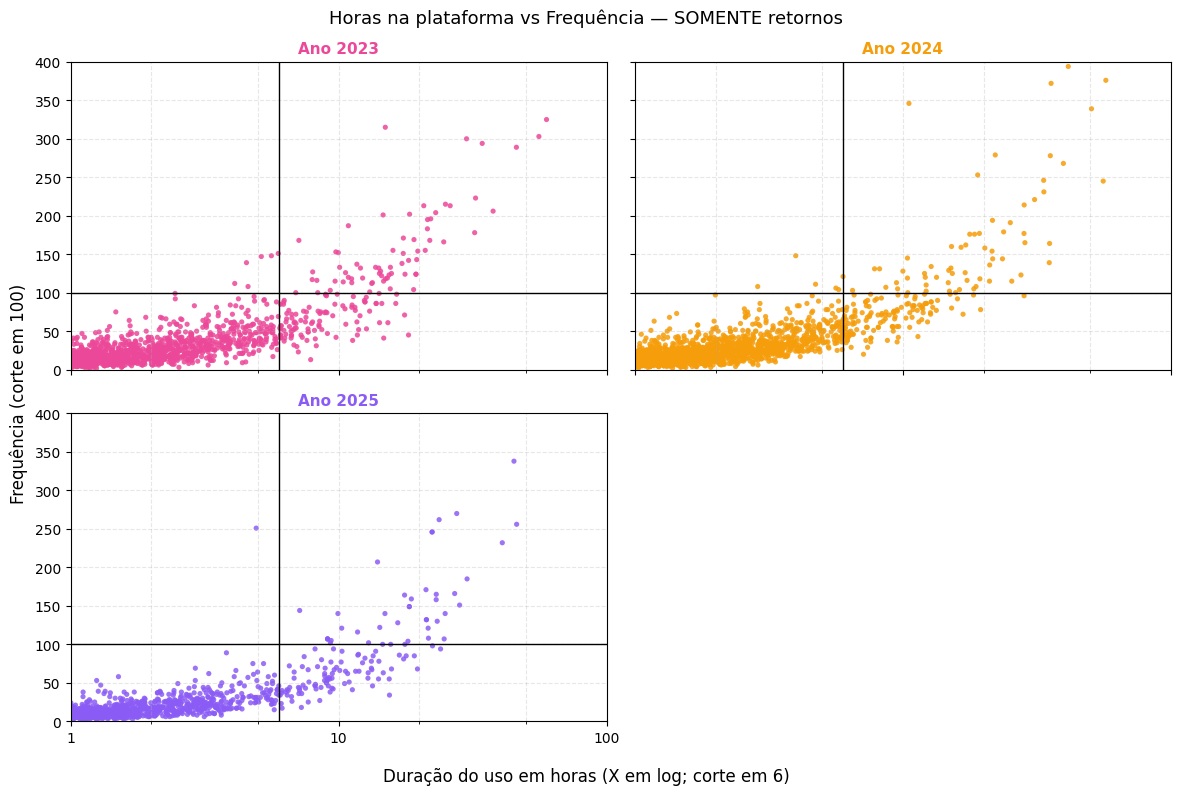

ano
2023    13486
2024    29116
2025    13333
Name: n_retornos, dtype: int64


In [67]:
xcol, ycol = "sessao_total", "frequencia"
x_max, y_max = 100, 400
x_thr, y_thr = 6, 100

# ---------- 1) Primeiro ano por unique_id (na base completa) ----------
first_year_map = (
    teachers_entries_agg_ano[["unique_id", "ano"]]
    .dropna(subset=["unique_id", "ano"])
    .groupby("unique_id")["ano"].min()
)

# ---------- 2) Preparar DF já SEM os primeiros acessos ----------
df = (
    teachers_entries_agg_ano[["unique_id", xcol, ycol, "ano"]]
    .dropna(subset=["unique_id", "ano", xcol, ycol])
    .copy()
)
df["first_year_for_id"] = df["unique_id"].map(first_year_map)
# mantém APENAS quem NÃO está no primeiro ano (retorno)
df = df[df["ano"] > df["first_year_for_id"]].copy()

# numéricos + filtros do gráfico
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()
df = df[(df[xcol] > 0) & (df[xcol] <= x_max) & (df[ycol] >= 0) & (df[ycol] <= y_max)]

# ---------- 3) Plot 2×2 por ano (somente retornos) ----------
anos = sorted(df["ano"].unique())
anos_plot = anos[-4:] if len(anos) > 4 else anos

palette = ["#ec4899", "#f59d0a", "#8b5cf5", "#3b2087"]
color_map = {a: palette[i] for i, a in enumerate(anos_plot)}

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

for i, ano in enumerate(anos_plot):
    ax = axes[i]
    d = df[df["ano"] == ano]

    ax.scatter(
        d[xcol], d[ycol],
        s=14, alpha=0.85, edgecolors="none", rasterized=True,
        color=color_map[ano]
    )

    ax.set_xscale("log")
    ax.set_xlim(1, x_max)
    ax.set_ylim(0, y_max)

    ax.axvline(x_thr, color="black", lw=1)
    ax.axhline(y_thr, color="black", lw=1)
    ax.grid(True, which="both", linestyle="--", alpha=0.3)
    ax.set_title(f"Ano {int(ano)}", fontsize=11, fontweight="bold", color=color_map[ano])

# esconder painéis vazios se houver < 4 anos
for j in range(len(anos_plot), 4):
    axes[j].set_visible(False)

# ticks em log bonitos
for ax in axes[:len(anos_plot)]:
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 5)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", ".")))

fig.suptitle("Horas na plataforma vs Frequência — SOMENTE retornos", fontsize=13)
fig.supxlabel("Duração do uso em horas (X em log; corte em 6)")
fig.supylabel(f"Frequência (corte em {y_thr})")
plt.tight_layout()
plt.show()

# (Opcional) verificar quantos pontos por ano foram plotados (retornos)
print(df.groupby("ano").size().rename("n_retornos"))


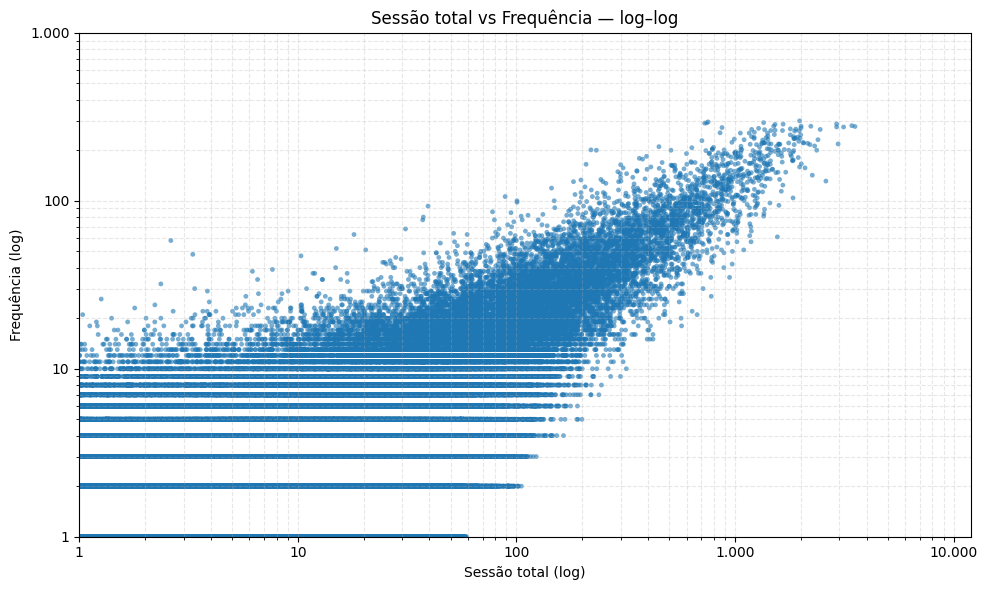

In [45]:
xcol, ycol = "sessao_total", "frequencia"

df = (
    teachers_entries_agg[[xcol, ycol]]
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
)

# filtros e > 0 para poder usar log
df = df[(df[xcol] > 0) & (df[xcol] <= 10_000) &
        (df[ycol] > 0) & (df[ycol] <= 300)]

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df[xcol], df[ycol], s=12, alpha=0.6, edgecolors="none", rasterized=True)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 12_000)
ax.set_ylim(1, 1_000)

# grades e formatação
ax.grid(True, which="both", linestyle="--", alpha=0.3)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.yaxis.set_major_locator(LogLocator(base=10))
fmt = FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", "."))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)

ax.set_xlabel("Sessão total (log)")
ax.set_ylabel("Frequência (log)")
ax.set_title("Sessão total vs Frequência — log–log")
plt.tight_layout(); plt.show()

C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\285593087.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(anos))
C:\Users\bazin\AppData\Local\Temp\ipykernel_18208\285593087.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


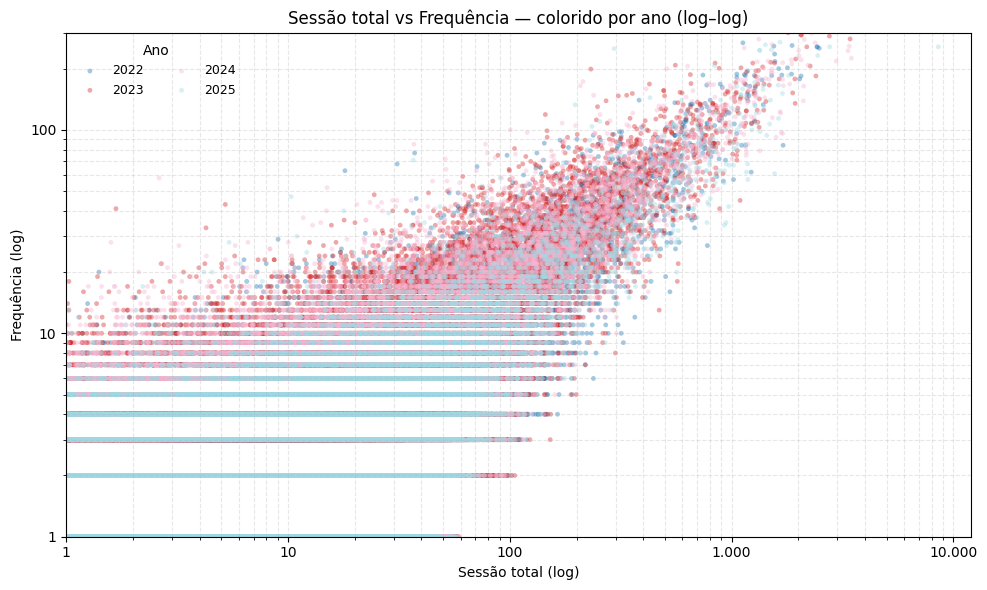

In [48]:
from matplotlib.ticker import LogLocator, FuncFormatter

xcol, ycol = "sessao_total", "frequencia"

# usa a base por ano
df = (
    teachers_entries_agg_ano[[xcol, ycol, "ano"]]
    .dropna(subset=[xcol, ycol, "ano"])
    .copy()
)
df[xcol] = pd.to_numeric(df[xcol], errors="coerce")
df[ycol] = pd.to_numeric(df[ycol], errors="coerce")
df = df.dropna()

# filtros e > 0 para log
df = df[(df[xcol] > 0) & (df[xcol] <= 10_000) &
        (df[ycol] > 0) & (df[ycol] <= 300)]

anos = sorted(df["ano"].unique())
cmap = plt.cm.get_cmap("tab20", len(anos))

fig, ax = plt.subplots(figsize=(10,6))
for i, ano in enumerate(anos):
    d = df[df["ano"] == ano]
    ax.scatter(
        d[xcol], d[ycol],
        s=12, alpha=0.4, edgecolors="none",
        color=cmap(i), label=str(int(ano))
    )

# escalas log
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 12_000)
ax.set_ylim(1, 300)

# grades e formatação
ax.grid(True, which="both", linestyle="--", alpha=0.3)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.yaxis.set_major_locator(LogLocator(base=10))
fmt = FuncFormatter(lambda v, p: f"{int(v):,}".replace(",", "."))
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)

ax.set_xlabel("Sessão total (log)")
ax.set_ylabel("Frequência (log)")
ax.set_title("Sessão total vs Frequência — colorido por ano (log–log)")
ax.legend(title="Ano", ncol=2, fontsize=9, frameon=False)

plt.tight_layout()
plt.show()


In [22]:
# Detecta o nome correto da coluna de média
xcol = "sessao_media" if "sessao_media" in teachers_entries_agg.columns else "sessao_media"

# Filtrar e limpar
plot_df = (
    teachers_entries_agg
    .loc[teachers_entries_agg["frequencia"] <= 5000, [xcol, "frequencia"]]
    .dropna()
)

print(f"n pontos: {len(plot_df):,}".replace(",", "."))

plt.figure(figsize=(10,6))
plt.scatter(
    plot_df[xcol], plot_df["frequencia"],
    alpha=0.5, s=8, edgecolors="none", rasterized=True
)
plt.xlabel("Sessão média")
plt.ylabel("Frequência (≤ 2000)")
plt.title("Sessão média vs Frequência (filtrado)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

KeyError: "['sessao_media'] not in index"

n pontos: 1.317.992


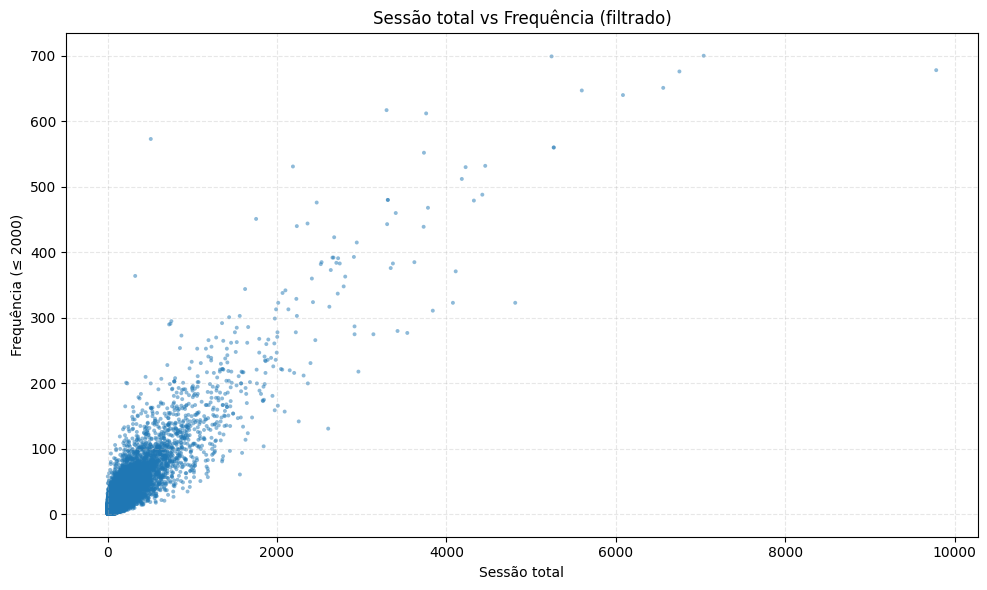

In [17]:
# Detecta o nome correto da coluna de média
xcol = "sessao_total" if "sessao_total" in teachers_entries_agg.columns else "sessao_total"

# Filtrar e limpar
plot_df = (
    teachers_entries_agg
    .loc[teachers_entries_agg["frequencia"] <= 800, [xcol, "frequencia"]]
    .dropna()
)

print(f"n pontos: {len(plot_df):,}".replace(",", "."))

plt.figure(figsize=(10,6))
plt.scatter(
    plot_df[xcol], plot_df["frequencia"],
    alpha=0.5, s=8, edgecolors="none", rasterized=True
)
plt.xlabel("Sessão total")
plt.ylabel("Frequência (≤ 2000)")
plt.title("Sessão total vs Frequência (filtrado)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

n pontos: 1.317.975


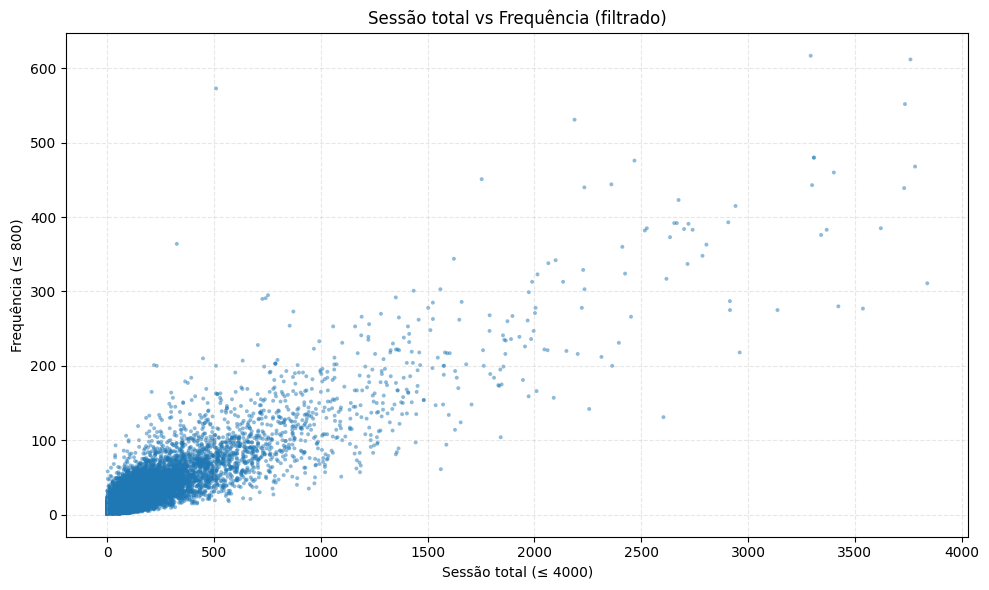

In [20]:
xcol = "sessao_total"  # aqui você quer 'sessao_total' mesmo

# Garantir que as colunas usadas estão numéricas
teachers_entries_agg[xcol] = pd.to_numeric(teachers_entries_agg[xcol], errors="coerce")
teachers_entries_agg["frequencia"] = pd.to_numeric(teachers_entries_agg["frequencia"], errors="coerce")

# Filtro combinado
mask = (teachers_entries_agg["frequencia"] <= 800) & (teachers_entries_agg[xcol] <= 4000)
plot_df = teachers_entries_agg.loc[mask, [xcol, "frequencia"]].dropna()

print(f"n pontos: {len(plot_df):,}".replace(",", "."))

plt.figure(figsize=(10,6))
plt.scatter(
    plot_df[xcol], plot_df["frequencia"],
    alpha=0.5, s=8, edgecolors="none", rasterized=True
)
plt.xlabel("Sessão total (≤ 4000)")
plt.ylabel("Frequência (≤ 800)")
plt.title("Sessão total vs Frequência (filtrado)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

n pontos: 1.305.751


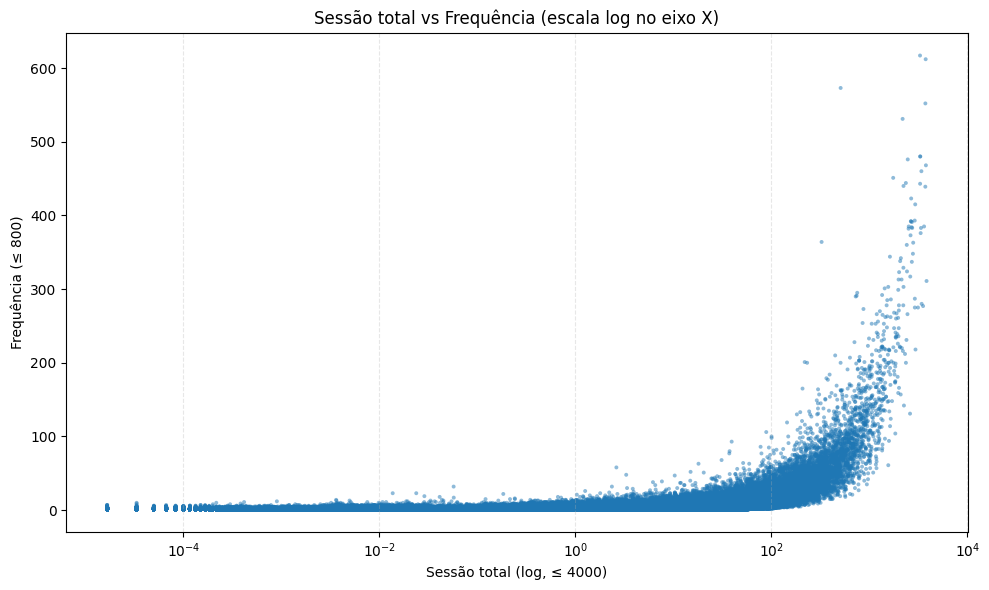

In [21]:
xcol = "sessao_total"

teachers_entries_agg[xcol] = pd.to_numeric(teachers_entries_agg[xcol], errors="coerce")
teachers_entries_agg["frequencia"] = pd.to_numeric(teachers_entries_agg["frequencia"], errors="coerce")

# Filtro combinado + > 0 para log
mask = (
    (teachers_entries_agg["frequencia"] <= 800) &
    (teachers_entries_agg[xcol] <= 4000) &
    (teachers_entries_agg[xcol] > 0)
)
plot_df = teachers_entries_agg.loc[mask, [xcol, "frequencia"]].dropna()

print(f"n pontos: {len(plot_df):,}".replace(",", "."))

plt.figure(figsize=(10,6))
plt.scatter(plot_df[xcol], plot_df["frequencia"], alpha=0.5, s=8, edgecolors="none", rasterized=True)
plt.xscale("log")  # <<< escala logarítmica no eixo X
plt.xlabel("Sessão total (log, ≤ 4000)")
plt.ylabel("Frequência (≤ 800)")
plt.title("Sessão total vs Frequência (escala log no eixo X)")
plt.grid(True, which="both", axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()